# Initial Hamming Weight experiment

With brute-force hyper parameter optimization of the MLP.

In [1]:
from math import floor

import numpy as np

from src.data.ascad import AscadRandomKey
from src.dlla.hw import fetch_traces
from src.dlla.wegener import make_mlp_wegener, class_reduction, wegener_p_gradient, wegener_t_test_p_gradient
from src.tools.lists import randomize
from src.tools.plotter import init_plots, plot_p_gradient
from src.tvla.tvla import Tvla

init_plots()

TRACE_LENGTH = 1400

In [2]:
ascad = AscadRandomKey().default

RANGE = (187, 203)

x_prof, y_prof, x_att, y_att = fetch_traces(ascad)

x_prof = x_prof[:, RANGE[0]:RANGE[1]]
x_att = x_att[:, RANGE[0]:RANGE[1]]

### Model creation

With model hyperparameters to be optimized.

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [3]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [4]:
X_PROF_2, Y_PROF_2 = class_reduction(x_prof, y_prof)
X_ATT_2, Y_ATT_2 = class_reduction(x_att, y_att)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)
MODEL_WEGENER = make_mlp_wegener(X_PROF_2, Y_PROF_2, X_ATT_2, Y_ATT_2)

Epoch 1/5
969/969 [==============================] - 2s 2ms/step - loss: 0.2508 - accuracy: 0.5066 - val_loss: 0.2500 - val_accuracy: 0.5069

In [5]:
def split_traces(x, y2):
    yam = np.argmax(y2, axis=1)
    a = x[np.where(yam)]
    b = x[np.where(~yam)]

    min_len = min(len(a), len(b))
    return a[:min_len], b[:min_len]

A_ATT, B_ATT = split_traces(X_ATT_2, Y_ATT_2)

Computing min-p gradients: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


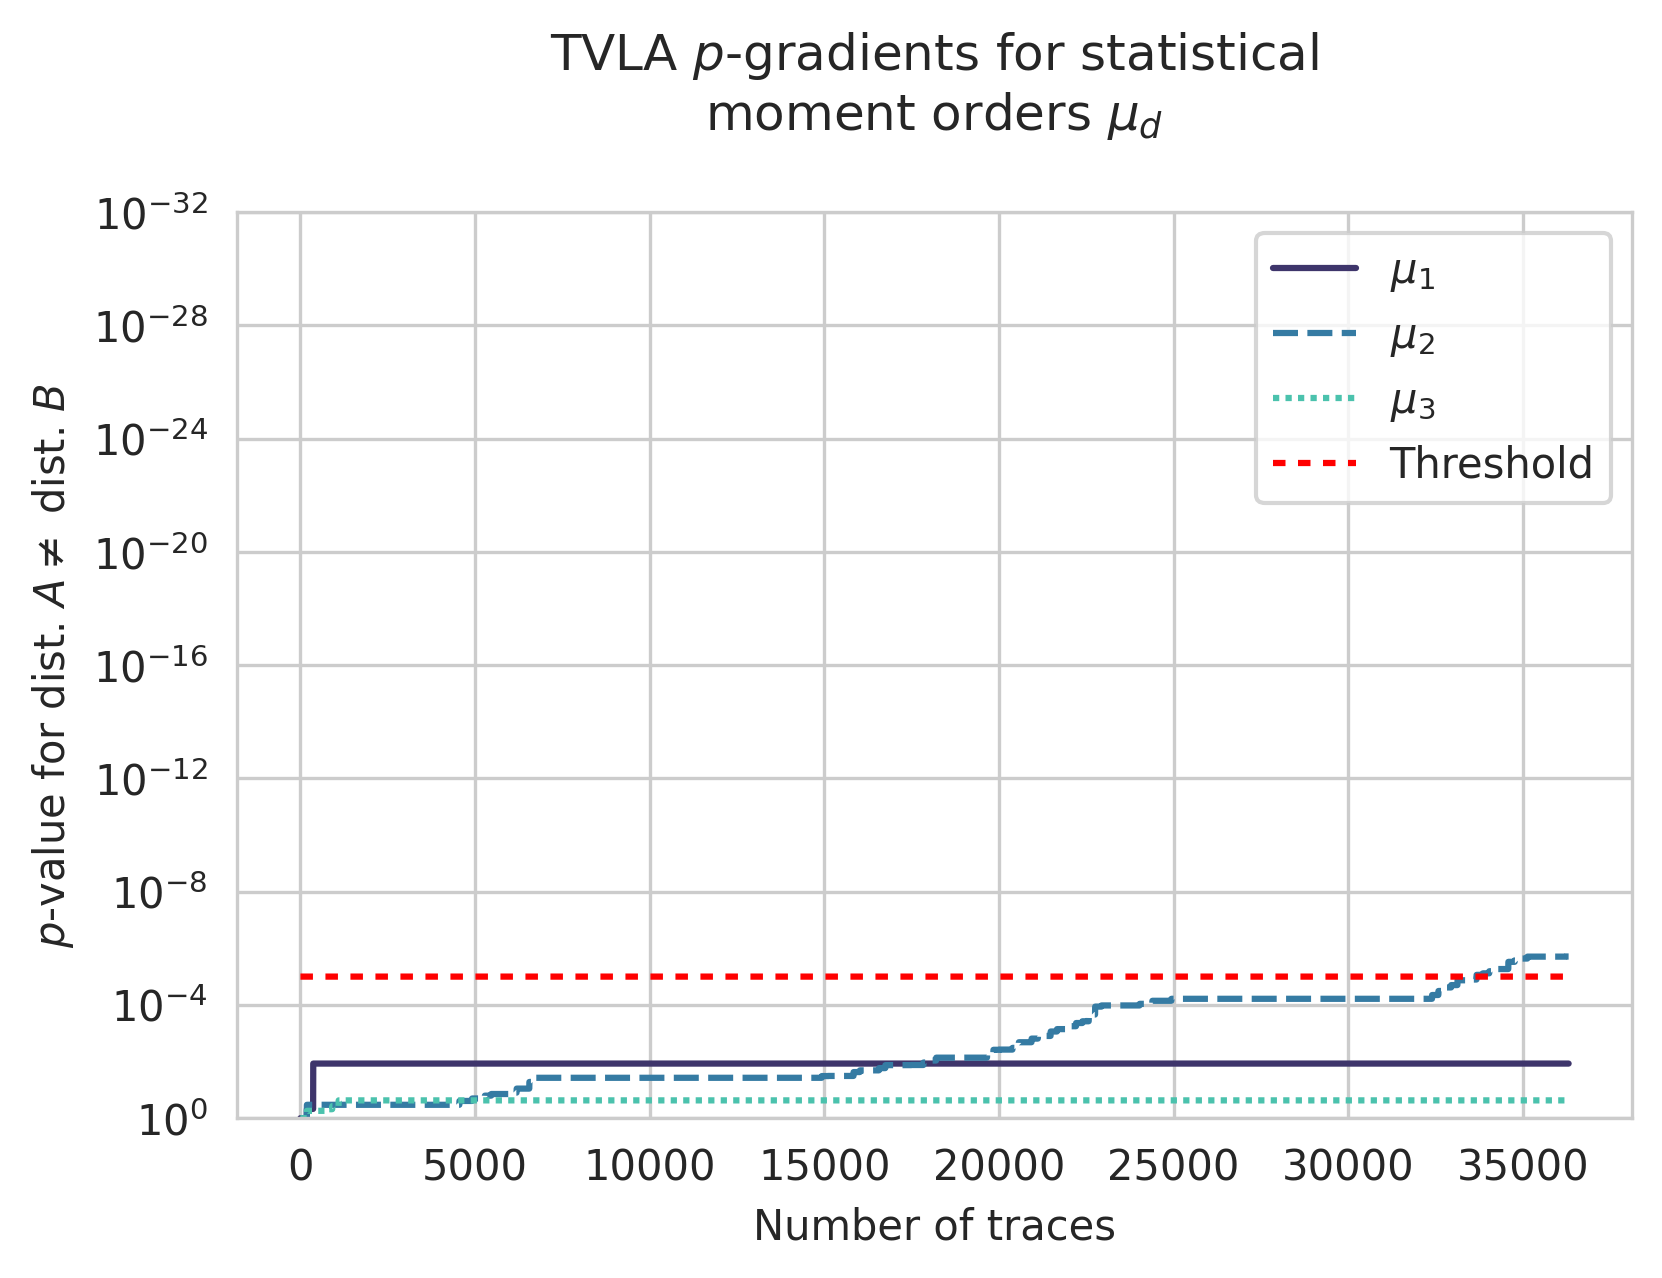

In [13]:
TVLA_AB = Tvla(A_ATT.shape[1])
TVLA_AB.add(A_ATT, B_ATT)
TVLA_AB.plot_gradients()

In [7]:
MAX_LEN = floor(len(X_ATT_2) / 2)
PG_WEGENER = wegener_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2)[:MAX_LEN]
PG_T_TEST = wegener_t_test_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2)[:MAX_LEN]

100%|██████████| 72616/72616 [00:00<00:00, 823541.32it/s]


In [8]:
PG_T_TEST

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       6.20128609e-22, 6.20128609e-22, 6.20128609e-22])

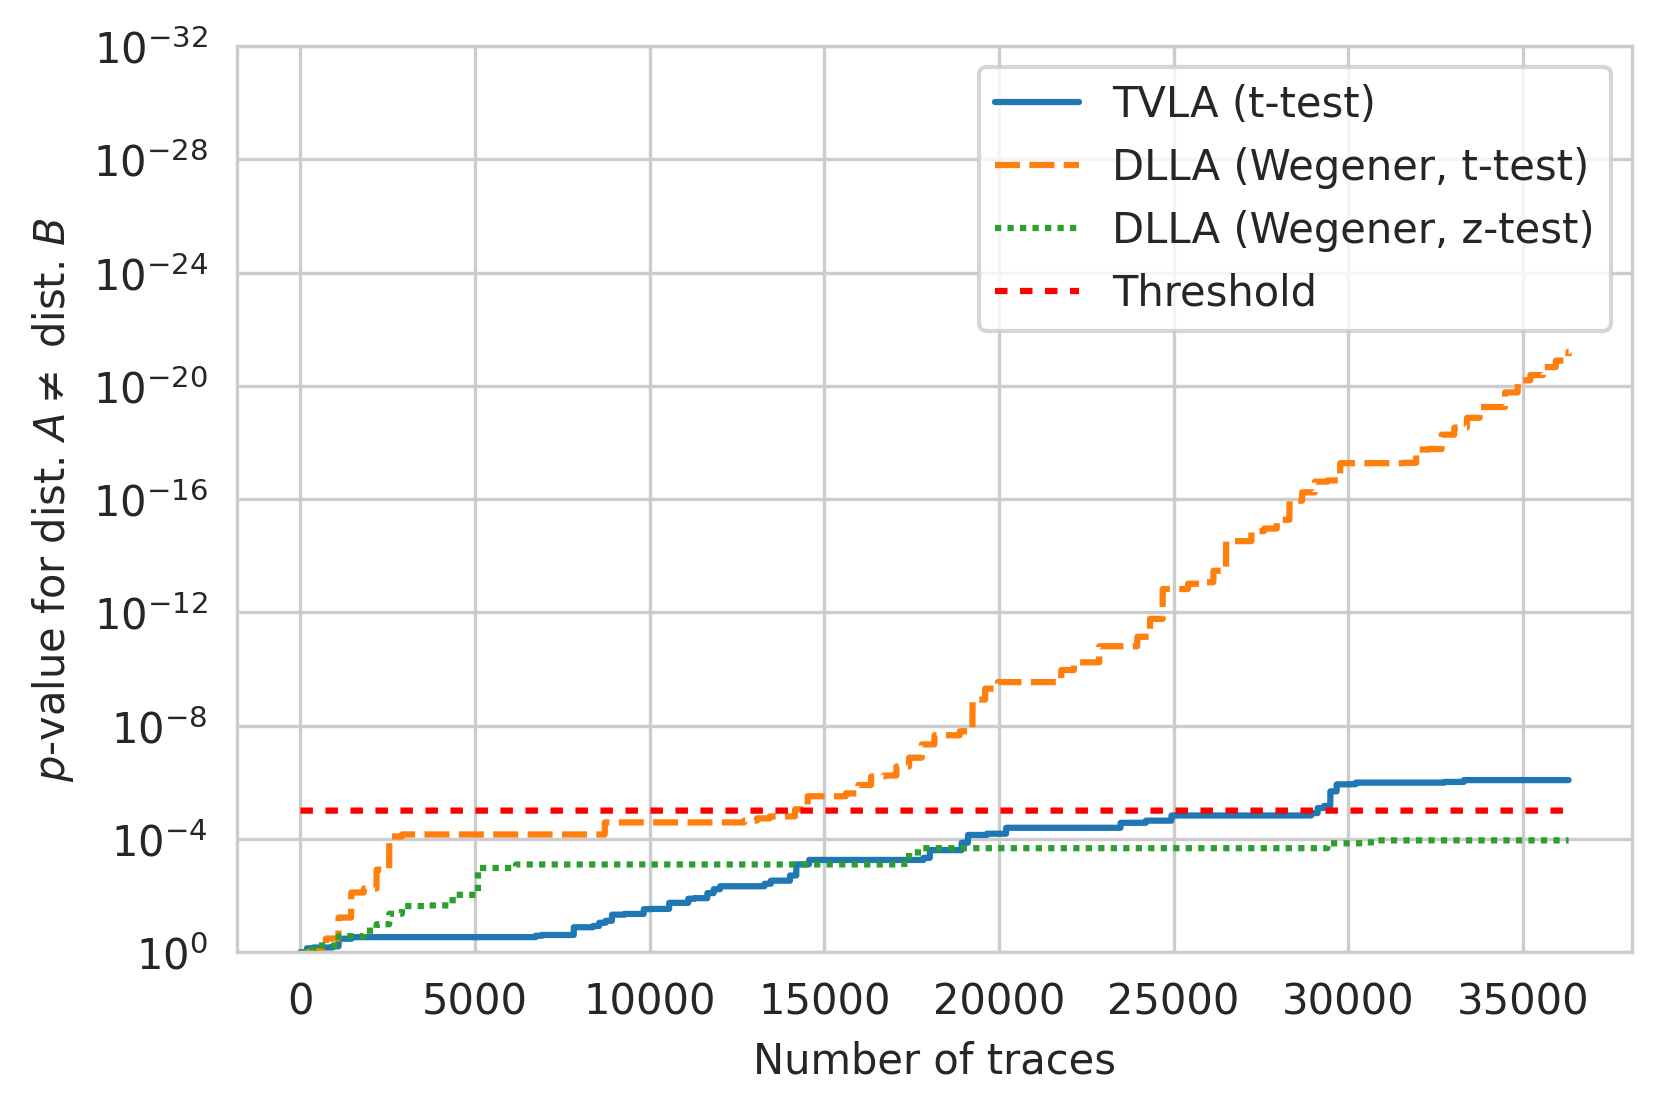

In [9]:
plot_p_gradient({"TVLA (t-test)": TVLA_AB.p_gradient(2),
                 "DLLA (Wegener, t-test)": PG_T_TEST,
                 "DLLA (Wegener, z-test)": PG_WEGENER})